# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
20,application_1619460320551_0021,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.1    
boto                       2.49.0   
click                      7.1.2    
jmespath                   0.10.0   
joblib                     0.16.0   
lxml                       4.5.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pip                        9.0.1    
py-dateutil                2.2      
python37-sagemaker-pyspark 1.4.0    
pytz                       2020.1   
PyYAML                     5.3.1    
regex                      2020.7.14
setuptools                 28.8.0   
six                        1.13.0   
soupsieve                  1.9.5    
tqdm                       4.48.2   
wheel                      0.29.0   
windmill                   1.6

In [2]:
sc.install_pypi_package("pandas==1.0.3")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

In [3]:
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

In [4]:
sc.install_pypi_package("seaborn==0.11.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/68/ad/6c2406ae175f59ec616714e408979b674fe27b9587f79d59a528ddfbcd5b/seaborn-0.11.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl

## Importing

Now, import the installed packages from the previous block below.

In [5]:
import pandas as pd

pd.set_option('display.max_rows', None, 'display.max_columns', None)

import matplotlib
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
import seaborn as sns
from pyspark.sql.functions import split, explode, substring, col, expr, count, avg, trim
from pyspark.sql import Window

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [6]:
df=spark.read.json('s3://sta9760-spark-yelp-dataset/business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [7]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 160,585

Display the DataFrame schema below.

In [8]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [9]:
df.createOrReplaceTempView('Yelp')
sqldf=spark.sql(
    '''
    SELECT business_id, name, city, state, stars, categories
    FROM Yelp
    LIMIT 5
    
    '''
)

view=sqldf.toPandas()
result=spark.createDataFrame(view)
result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+-----------+-----+-----+--------------------+
|         business_id|                name|       city|state|stars|          categories|
+--------------------+--------------------+-----------+-----+-----+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|    Boulder|   CO|  4.0|Gastropubs, Food,...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...|   Portland|   OR|  4.0|Salad, Soup, Sand...|
|bvN78flM8NLprQ1a1...|      The Reclaimory|   Portland|   OR|  4.5|Antiques, Fashion...|
|oaepsyvc0J17qwi8c...|         Great Clips|Orange City|   FL|  3.0|Beauty & Spas, Ha...|
|PE9uqAjdw0E4-8mjG...|   Crossfit Terminus|    Atlanta|   GA|  4.0|Gyms, Active Life...|
+--------------------+--------------------+-----------+-----+-----+--------------------+

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [10]:
category_df=df['business_id','categories']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
output=category_df.withColumn('category',explode(split('categories',',')))
output = output.drop('categories')
output = output.withColumn("category", trim(col("category")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [12]:
output.limit(5).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+
|         business_id|    category|
+--------------------+------------+
|6iYb2HFDywm3zjuRg...|  Gastropubs|
|6iYb2HFDywm3zjuRg...|        Food|
|6iYb2HFDywm3zjuRg...|Beer Gardens|
|6iYb2HFDywm3zjuRg...| Restaurants|
|6iYb2HFDywm3zjuRg...|        Bars|
+--------------------+------------+

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [13]:
output.select(f.countDistinct("category")).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------+
|count(DISTINCT category)|
+------------------------+
|                    1330|
+------------------------+

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [14]:
data_counts = output.groupBy("category").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
data_counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|      Dermatologists|  351|
|      Paddleboarding|   67|
|        Aerial Tours|    8|
|         Hobby Shops|  610|
|          Bubble Tea|  779|
|             Embassy|    9|
|             Tanning|  701|
|            Handyman|  507|
|      Aerial Fitness|   13|
|             Falafel|  141|
|        Summer Camps|  308|
|       Outlet Stores|  184|
|     Clothing Rental|   37|
|      Sporting Goods| 1864|
|     Cooking Schools|  114|
|  College Counseling|   20|
|  Lactation Services|   47|
|Ski & Snowboard S...|   55|
|             Museums|  336|
|              Doulas|   52|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [16]:
pdf=data_counts.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
plot_df=pdf.nlargest(20, 'count')
plot_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                       category  count
1225                Restaurants  50763
21                         Food  29469
1202                   Shopping  26205
851               Beauty & Spas  16574
713               Home Services  16465
1198           Health & Medical  15102
1320             Local Services  12192
913                   Nightlife  11990
539                        Bars  10741
419                  Automotive  10119
108   Event Planning & Services   9644
106                 Active Life   9231
959                Coffee & Tea   7725
728                  Sandwiches   7272
328                     Fashion   6599
488      American (Traditional)   6541
553                 Hair Salons   5900
412                       Pizza   5756
1004            Hotels & Travel   5703
88           Breakfast & Brunch   5505

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

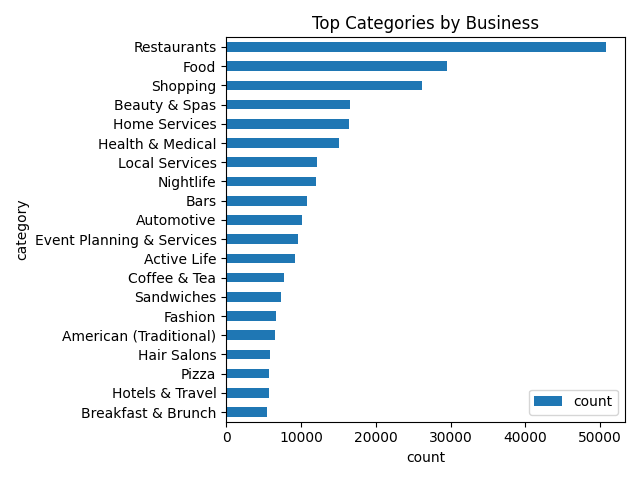

In [18]:
plt.figure(figsize=(10,6))

plot_df.sort_values(by='count', ascending=True).plot.barh(x='category', y='count')

plt.title('Top Categories by Business')
plt.xlabel('count')
plt.ylabel('category')

plt.tight_layout()
plt.show()
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [19]:
reviews_df=spark.read.json('s3://sta9760-spark-yelp-dataset/yelp_academic_dataset_review.json')
print(f'Total Columns: {len(reviews_df.dtypes)}')
print(f'Total Rows: {reviews_df.count():,}')
reviews_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 9
Total Rows: 8,635,403
root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [20]:
reviews_df.createOrReplaceTempView('Yelp')
sqldf_reviews=spark.sql(
    '''
    SELECT business_id, stars
    FROM Yelp
    LIMIT 5
    
    '''
)

view=sqldf_reviews.toPandas()
result1=spark.createDataFrame(view)
result1.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|buF9druCkbuXLX526...|  4.0|
|RA4V8pr014UyUbDvI...|  4.0|
|_sS2LBIGNT5NQb6PD...|  5.0|
|0AzLzHfOJgL7ROwhd...|  2.0|
|8zehGz9jnxPqXtOc7...|  4.0|
+--------------------+-----+

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [21]:
stars=reviews_df['business_id','stars']
stars_spark=stars.groupBy("business_id").mean("stars")
stars_spark.limit(5).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|uEUweopM30lHcVxjO...|              3.0|
|wdBrDCbZopowEkIEX...|4.538461538461538|
|L3WCfeVozu5etMhz4...|              4.2|
|bOnsvrz1VkbrZM1jV...|              3.8|
|R0IJhEI-zSJpYT1YN...|3.606060606060606|
+--------------------+-----------------+

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [22]:
result_all=df['business_id','stars','name','city','state']
merged=stars_spark.join(result_all, ['business_id'])
merged=merged.drop('business_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [23]:
mergedTop5=merged.limit(5).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+
|        avg(stars)|stars|                name|      city|state|
+------------------+-----+--------------------+----------+-----+
|               5.0|  5.0|    CheraBella Salon|   Peabody|   MA|
|             3.875|  4.0|Mezcal Cantina & ...|  Columbus|   OH|
|3.8666666666666667|  4.0|    Red Table Coffee|    Austin|   TX|
|               5.0|  5.0|          WonderWell|    Austin|   TX|
|             3.375|  3.5|         Avalon Oaks|Wilmington|   MA|
+------------------+-----+--------------------+----------+-----+

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [24]:
skew_df=merged.withColumn('skew', ((merged['avg(stars)'] - merged['stars']) / merged['stars']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

In [25]:
graph=skew_df.toPandas()
skewGraph=graph['skew']

plt.clf()
#skewGraph.plot.hist(density=True, bins=30, color = "steelblue", edgecolor="none")
ax=sns.histplot(data=skewGraph,stat='density',kde=True,color='steelblue',bins=50).set_xticks([-0.5,-0.25,0,0.25,0.5,0.75,1.0,1.25])
#ax=sns.distplot(graph['skew'],kde=True,color='steelblue',bins=bins).set_title("Top Categories by Business")

plt.title('Top Categories by Business')
plt.xlabel('k')

plt.tight_layout()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

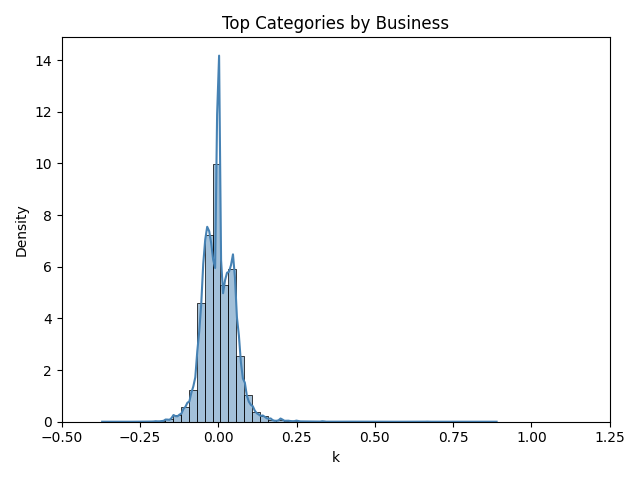

In [26]:
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

### From the graph plotted, I think that the Yelp reviews are skewed more positive since the tail on the right side is longer. That means that the median and the mean will be greater than the mode.

# Correlation Heatmap

In [37]:
rev_df=reviews_df['cool','funny','stars','useful']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
correlation=rev_df.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
corr=correlation.corr()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
plt.clf()

sns.heatmap(corr, center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

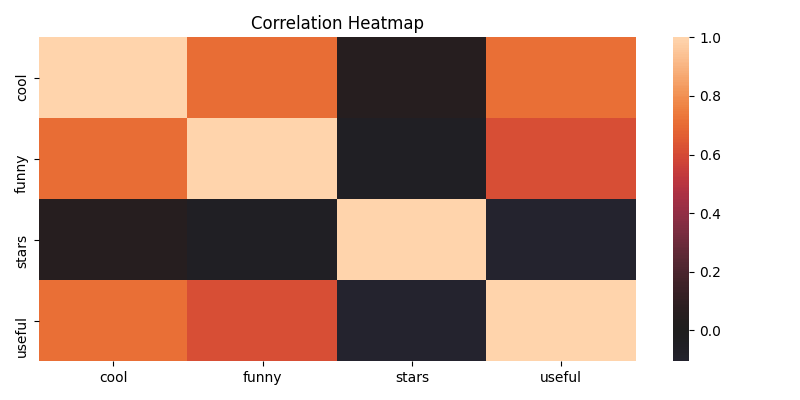

In [45]:
%matplot plt

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [30]:
users_df=spark.read.json('s3://sta9760-spark-yelp-dataset/yelp_academic_dataset_user.json')
users_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [31]:
starsData=users_df['cool','funny','name']
starsData.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+----------+
| cool|funny|      name|
+-----+-----+----------+
|11291|10030|      Jane|
|18046|10289|      Gabi|
|  130|  128|     Jason|
| 4035| 4722|       Kat|
| 1124|  727| Christine|
|  140|  101|   Natasha|
|   16|   14|   Bridget|
|   44|   47|    Steven|
|  121|  106|     Clara|
|  306|  220|Antoinette|
|  138|  176| Hollyanna|
|   77|   66|       Joe|
|  893|  801|     Damon|
|  629|  468|       Ben|
|    0|    0|     Bryan|
|  522|  609|  Cristina|
| 1556| 1282|      Cara|
|  102|   40|    Jessie|
|  230|  103|      Lisa|
|   12|   25|     silly|
+-----+-----+----------+
only showing top 20 rows

In [32]:
businessData=df['name','business_id']
mergeUsers=businessData.join(starsData, ['name'])
mergeUsers=mergeUsers.drop('name')
mergeUsers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+-----+
|         business_id|cool|funny|
+--------------------+----+-----+
|giLX7ndl5XYIjq6o0...| 182|  277|
|ItHjEkDdEYIHBW5i4...|1844| 1366|
|iBIKBPmZ3mVuMnHc2...| 625|  479|
|WBGGwHNHRDGUzTtrO...| 697|  572|
|dtR1VUvUTTVRxs5rr...|8126| 4365|
|dtR1VUvUTTVRxs5rr...|  14|   12|
|Af2kgWjIoS_N-A5oT...|  18|   26|
|nb2NeOHk_PNPvlbvH...|  40|   55|
|26KhDZ-ez6mWfiZQ8...|  40|   55|
|4RH5yxIM52U-BuwPT...|  40|   55|
|vGPmLdfjabtUO6o4l...|  40|   55|
|-Yt1oOD4xufkz6lIj...| 192|  229|
|-Yt1oOD4xufkz6lIj...|  15|    9|
|dtR1VUvUTTVRxs5rr...| 378|  360|
|giLX7ndl5XYIjq6o0...| 135|  198|
|-Yt1oOD4xufkz6lIj...|   6|   14|
|-Yt1oOD4xufkz6lIj...|  35|   13|
|3p4MTzaGC6k5BAb1I...|  27|   39|
|-Yt1oOD4xufkz6lIj...|1006| 1116|
|-Yt1oOD4xufkz6lIj...|  14|    3|
+--------------------+----+-----+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

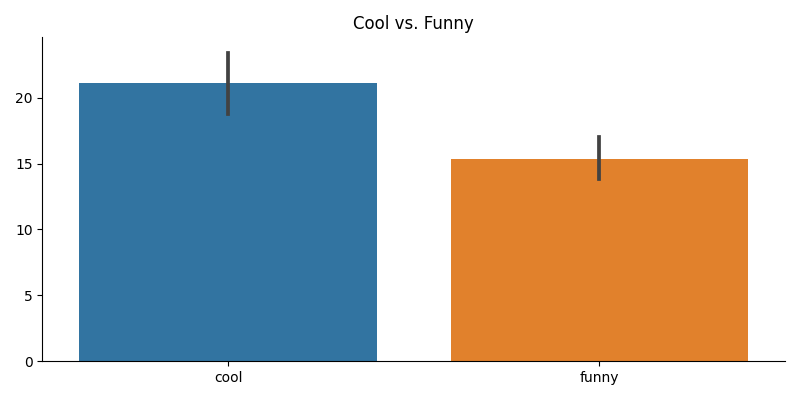

In [46]:
combined=mergeUsers.toPandas()

plt.clf()
ax1=sns.factorplot(data=combined,size=4,aspect=2,kind='bar')
plt.tight_layout()
plt.show()
plt.title('Cool vs. Funny')

plt.tight_layout()
%matplot plt

## The End